Starting simulations.........

Enter an integer from 0 to 3 (anything more than 3 will be interpreted as 3). Option 0 simulates the two player market with matrix [[0.99, 0.1], [10.2, 0.99]]; option 1 generates the market with 101 players read from a file and equal initial bids (i.e. b_ij = 1/n^2 for all i,j); option 2 simulates the star market with 4 players; option 3 (or more) simulates a market with random number of players and random matrix and random initial bids3
You chose option 3
Simulating a random economy with random number of players and random matrix and initial bids
The time horizon is:: 400 ; if you want to change it, edit the TIME parameter at the top of the file
The number of players is:: 7
The matrix a is:: [[0.999388, 0.848755, 1.554323, 0.732857, 1.422752, 0.669614, 0.582169], [0.881639, 0.298726, 0.607737, 1.516677, 0.324635, 0.369641, 1.269969], [0.468025, 1.18191, 0.141183, 1.099249, 0.144828, 1.195504, 1.559649], [1.809222, 1.621279, 1.299042, 1.438158, 0.382611, 

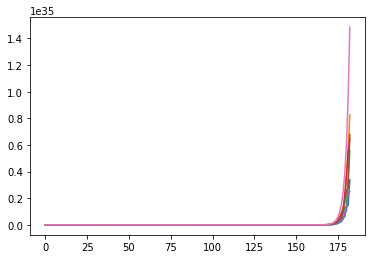

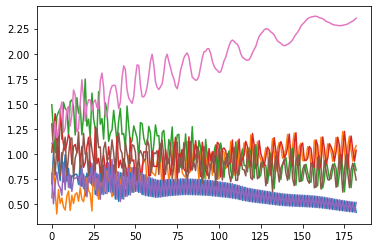

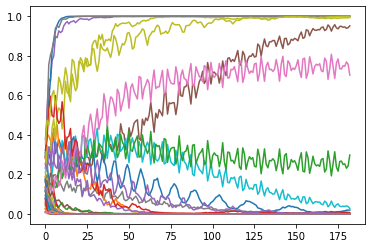

n:: 7 Final total: 1.1934589228498006e+36
Final amounts: [8.252479812308253e+34, 2.237902609632164e+35, 8.893901273071703e+34, 2.2475794742577596e+35, 6.1021226214599895e+34, 1.4853492827814541e+35, 3.6389074911426345e+35]
The simulation was done for  184  rounds


In [15]:
import random
import numpy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pylab
import csv
import os

TIME = 400


OPTION = 0 # will have some default options, like to generate the two player market, and then the last option is for 
MAX_ROUND_DISPLAY = 1000 # plot only the f8rst few rounds, even if the iteration is run for longer

def detect_cycle(n,a,d,z):
    for i in range(n):
        for j in range(n):
            if d[i] + z[i][j] < d[j]:
                return j
    return -1

def cycle(n,a): # check if the weighted graph has a good cycle
    d = [float('inf') for e in range(n)] # initialize the 'distance' to 0 for all
    d[0] = 0.0 # except player 0
    
    # create equivalent matrix where we will find a negative cycle
    z = [[0.0 for e in range(n)] for e in range(n)]
    for i in range(n):
        for j in range(n):
            z[i][j] = - math.log(a[i][j], 2)
        
    #print("the z matrix::",z)
    s = [-1 for e in range(n)] # player 0 as the source
    s[0] = 0 # player 0 has itself as a parent

    for k in range(n-1):
        for i in range(n):
            for j in range(n):
                if d[i] + z[i][j] < d[j]:
                    d[j] = d[i] + z[i][j]
                    s[j] = i

    # one more relaxation, in round n
    k = detect_cycle(n,a,d,z)
    if k == -1:
        return False
    c = [0 for e in range(n)]
    while c[k] <= 0:
        c[k] = c[k] + 1
        k = s[k]
    
    # Print the cycle
    visited = [False for e in range(n)]
    ll = k
    while visited[ll] == False:
        print(ll)
        visited[ll] = True
        ll = s[ll]
    
    return True

def total(n,x):
    gdp = 0.0
    for i in range(n):
        gdp += x[i]
    return gdp
# trading: input number of players, utility coefficients, initial bids, initial budgets
def trade(n,a,x,b,B):
    
    #print("Entering trade")
    r = 1
    
    p = [0.0 for e in range(n)] # price of each good
       
    for j in range(n):
        for i in range(n):
            p[j] += b[i][j]
    
    # y_ij is the quantity received by player i from good j (i.e. fraction invested by player i compared to total investment on j * quantity of good j)
    y = [[0.0 for e in range(n)] for e in range(n)] 
    for j in range(n):
        bb = 0
        for k in range(n):
            bb += math.pow(b[k][j],r)
            
        if bb > 0: # if p[j] > 0: # the good only gets allocated if someone bids on it
            for i in range(n):   
                aa = math.pow(b[i][j], r)
                # Proportional allocation rule: y[i][j] = (b[i][j] / p[j]) * x[j]  
                y[i][j] = aa / bb * x[j]

    xn = [0.0 for e in range(n)] # quantities after production (each player i produces from bundle y_i)
    for i in range(n):
        for j in range(n):
            xn[i] += a[i][j] * y[i][j]
           
    Bn = p # the new budgets; each player j collects the money from selling good j (i.e. the price of good j becomes the new budget of player j)

    #print("The new quantities are::",xn)
    bn = [[0.0 for e in range(n)] for e in range(n)] # new bids, updated proportionally to how useful each good was in the final production
    for i in range(n):
        for j in range(n):
            if xn[i] > 0:
                bn[i][j] = (a[i][j] * y[i][j] / xn[i]) * Bn[i]     
            else: # shouldn't be entering here with non-degenerate start state and non-trivial graph, but running for too many iterations may make things zero...
                bn[i][j] = (b[i][j] / B[i]) * Bn[i] # if the player has zero quantity, leave the fractions the same as in the previous round

    #print("Exiting trade")
    return (xn,bn,Bn) # new quantities, bids, and budgets

def is_infinite(n,x):
    if total(n,x) > 999999999999999999999999999999999999:
        return True
    
    for i in range(n):
        if x[i] == float('+inf'):
            return True
    return False
  
def gen_bids(n):
    #b = [[1/n for e in range(n)] for e in range(n)]
    
    b = [[random.uniform(0.01,0.99) for e in range(n)] for e in range(n)]
        
    # correct the division errors in the bids
    for i in range(n):
        S = 0.0
        for j in range(n):
            S = S + b[i][j]
        for j in range(n-1):
            b[i][j] = b[i][j] / S
        SS = 0.0
        for j in range(n-1):
            SS += b[i][j] 
        b[i][n-1] = 1 - SS       
           
    for i in range(n):
        s = 0
        for j in range(n-1):
            s += b[i][j]
        b[i][n-1] = 1 - s
            
    return b

def gen_ring(n): # return a matrix for a ring with self loops
    a = [[0.0 for e in range(n)] for e in range(n)]
    
    p = 1
    for i in range(n-1):
        a[i][i] = round(random.uniform(0.00001, 1.8), 8)
        a[i][i+1] = round(random.uniform(0.00001,0.09),8)
        p = p * a[i][i+1]
        
    a[n-1][n-1] = round(random.uniform(0.00001, 1.8), 8)
        
    p1 = 1/p
    a[n-1][0] = round(p1,4) - 0.01
    
    while (p * a[n-1][0] < 1):
        a[n-1][0] += 0.1
    
    print("The product along the ring is:",p*a[n-1][0])

    return a

def gen_bipartite(n):
    a = [[0.0 for e in range(n)] for e in range(n)]

    k = 1 #random.randint(1,n-1) # the players will be divided in 2 sets, from 0 to k and from k+1 to n-1
    
    A = [i for i in range(0,k)] # the first set has players from 0 to k-1
    B = [i for i in range(k,n)] # the second set has players from k to n-1

    #A = [0] 
    #B = [1,2,3,4,5,6,7,8,9]
    
    print("A::",A,"B::",B)
    
    for ia in A:
        for ib in B:
            a[ia][ib] = round(random.uniform(0.01,2),2)
            a[ib][ia] = 1/a[ia][ib]-0.01
            print(a[ia][ib],",",a[ib][ia])
#            a[ib][ia] = round(random.uniform(0.01,2),2)
  #  print("The a matrix::",a)
    ## Make one edge good
    i = A[0]
    j = B[0]
    
    a[i][j] = round(random.uniform(0.01,2),2)
    a[j][i] = 0.1 + round(1/a[i][j],6)  
    
    # Bid of player 0 cycles forever: n=10 players, matrix:: a = [[0.0, 0.0, 1.48, 1.33, 0.14, 1.52, 0.87, 0.27, 0.22, 0.93], [0.0, 0.0, 1.64, 0.38, 1.31, 0.87, 0.31, 0.38, 0.08, 1.26], [1.31, 1.52, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.36, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.56, 1.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.23, 1.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.42, 1.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04, 1.94, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.29, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.18, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    #a = [[0.0, 0.51, 0.33, 0.49, 0.9, 0.35, 1.08, 0.07, 1.13, 1.36], [0.52, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.78, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.73, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    
    pp = [0.0 for e in range(n)]
    for i in range(1,n):
        pp[i] = a[0][i] * a[i][0]

    print("************************\nThe product along the pairs is::\n",pp)
    
    return a

# generate a flower with some number of petals so that the total number of players is n
# at least one of the petals is a good cycle
def gen_flower(n):
    a = [[0.0 for e in range(n)] for e in range(n)]
    
    flower = []
    
    k = 1 # players from k to n available for new petals
    while k < n:
        petal = []
        s = random.randint(k+1,n) # random start point of the petal after this one; its players are from k to s
        for i in range(k,s):
            petal.append(i)
        flower.append(petal)
        k = s
    
    print("The flower is::",flower)
    print("Number of petals",len(flower))
    print("The petals are::")
    for i in range(len(flower)):
        print("Petal",i,"::",flower[i])
 
    # Make the first petal good
    p = 1
    good_petal = flower[0]
    good_petal.insert(0,0) # add player 0 to it first
    for j in range(len(good_petal)-1):
        a[good_petal[j]][good_petal[j+1]] = round(random.uniform(0.01,3),8)
        print("a(",good_petal[j],",", good_petal[j+1],")::",a[good_petal[j]][good_petal[j+1]])
        p = p * a[good_petal[j]][good_petal[j+1]]

    p1 = 1/p
    a[good_petal[len(good_petal)-1]][0] = round(p1,4) + 0.01
    print("a",len(good_petal)-1,",", 0,"::",a[good_petal[len(good_petal)-1]][0])

    print("The product along the petal is::",p*a[good_petal[len(good_petal)-1]][0])

    for i in range(1,len(flower)):
        p = 1
        petal = flower[i]
        petal.insert(0,0) # add player 0
        for j in range(len(petal)-1):
            a[petal[j]][petal[j+1]] = round(random.uniform(0.01,3),8)
            print("a(",petal[j],",", petal[j+1],")::",a[petal[j]][petal[j+1]])
            p = p * a[petal[j]][petal[j+1]]
        p1 = 1/p
        a[petal[len(petal)-1]][0] = p1 - 0.1
        print("a(",len(petal)-1,",", 0,")::",a[petal[len(petal)-1]][0])

        print("The product along the petal is::",p*a[petal[len(petal)-1]][0])
    
    return a

def gini(n,z):
    s = t = 0.0
    for i in range(n):
        for j in range(n):
            s = s + abs(z[i] - z[j])
        t = t + z[i]
            
    t = t * 2 * n
    return s/t

def print_final(n,a,x,b,B,final_round,m_frac, m_bids, m_budgets, m_quantities):
    
    print("Final round is::", final_round)
    print("Final amounts",x)
    
    print("Final budgets",B)
        
    T = min(MAX_ROUND_DISPLAY,final_round-1)

    
    plt.figure(1)
    # Printing the quantities first 
    print("Figure 1::the quantities of the players\n")
    for j in range(n):
        plt.plot(m_quantities[j][0:T])
    
    plt.figure(2)
    # Printing the budgets 
    print("Figure 2::the budgets of the players\n")
    for j in range(n):
        plt.plot(m_budgets[j][0:T])
    
    plt.figure(3)
    print("Figure 3::the fractions b_ij/B_i that each player i invests in good j, for all pairs (i,j)\n")
    for i in range(n): 
        for j in range(n):
            plt.plot(m_frac[n*i+j][0:T])
              
    plt.show() 
    
# Plot vector field for two players
    
def price(n, b, j):
    p = 0
    for i in range(n):
        p = p + b[i][j]
    return p

def sim(n,a,b,B):
    
    x = [1.0 for e in range(n)] # amount of each good, initialized to 1 
    
    # Some memory vectors and matrices to remember stuff from each round so that we can plot it later
    m_frac = [[1.0 for e in range(TIME+1)] for e in range(n*n)] # memory vector with the fractions; m_frac[i][j] = b[i][j] / B[i] (the fraction of the budget that agent i invests in good j)
    m_bids = [[1/(n) for e in range(TIME + 1)] for e in range(n*n)] # memory vevtor with the bids 
    m_budgets = [[1 for e in range(TIME + 1)] for e in range(n)] # memory vector with the budgets
    m_quantities = [[1 for e in range(TIME + 1)] for e in range(n)] # memory vector with the quantities

        
    # To add a check that there is a good cycle, the next line should be "if not cycle(n,a):"
    if False: #not cycle(n,a):
        print("No good cycle")
        return 0 # this instance cannot be problematic because there are no good cycles to begin with
    
    ## Economy dynamics goes in here
    
    for t in range(TIME):
          
        #print("Simulating round", t)

        (x,b,B) = trade(n,a,x,b,B)
                  
        for i in range(n):
            m_budgets[i][t] = B[i]
            m_quantities[i][t] = x[i]
            
            for j in range(n):
                m_bids[n*i+j][t] = b[i][j]
                m_frac[n*i+j][t] = b[i][j]/B[i]
        
        if is_infinite(n,x): # this is a check in case the amounts got out of hand or the prices are almost zero, stop the simulation early
            return (t, x, b, B, m_frac, m_bids, m_budgets, m_quantities)

    return (TIME,x,b,B,m_frac, m_bids, m_budgets, m_quantities)

def show_heatmap(data,title,M,d):
    
    plt.title(title)
    x, y = numpy.linspace(0, M/d, num = M), numpy.linspace(0, M/d, num=M)
    X, Y = numpy.meshgrid(x, y)
    
    heatmap = plt.pcolor(X,Y,data)
    plt.colorbar()
    plt.show()
    
def read_matrix_from_file(n):
    
    a = [[0 for e in range(n)] for e in range(n)]
    notebook_path = os.path.abspath("Notebook.ipynb")
    data_csv = os.path.join(os.path.dirname(notebook_path), "weighted-graph.csv")

    f = open(data_csv)
    t = 0 
    for row in csv.reader(f):
        print(row)
        if t > 0:
            i = int(row[0])
            j = int(row[1])
            weight = float(row[2])
            a[i][j] = weight
        t = t + 1

    return a

# generate a random matrix. Get number of players as input
def gen_matrix(n):
    l = [[round(random.uniform(0.1, 2), 6) for i in range(n)] for j in range(n)]
    return l

def main():
    
    n = 2 
    
    a = [[0.99, 0.1], [10.2, 0.99]]
    
    b = [[1/(n) for e in range(n)] for e in range(n)]

    print("Starting simulations.........\n")

    #print("Type an integer from 0 to 2: 0 is to generate the two player market with matrix [[0.99, 0.1], [10.2, 0.99]]; 1 is to generate the market with 101 players read from a file and equal initial bids; 2 is to generate a market with random number of players and random matrix")
    
    num = int(input("Enter an integer from 0 to 3 (anything more than 3 will be interpreted as 3). Option 0 simulates the two player market with matrix [[0.99, 0.1], [10.2, 0.99]]; option 1 generates the market with 101 players read from a file and equal initial bids (i.e. b_ij = 1/n^2 for all i,j); option 2 simulates the star market with 4 players; option 3 (or more) simulates a market with random number of players and random matrix and random initial bids"))
    
    
    print("You chose option", num)
    
    if num == 0: # generate two player economy 
        print("Simulating the economy with two players, matrix [[0.99, 0.1], [10.2, 0.99]]")
        a = [[0.99, 0.1], [10.2, 0.99]]
        b = [[1/(n) for e in range(n)] for e in range(n)]
        
    elif num == 1: # generate the economy with data read from file 
        print("Simulating the economy with n = 101 players, reading the data from a file")
        n = 101
        a = read_matrix_from_file(n)
        b = [[1/(n) for e in range(n)] for e in range(n)]
        
    elif num == 2: # generate the star economy with 4 players
        print("Simulating the star economy with 4 players")
        n = 4 
        a = [[0, 0, 0, 0.7], [0, 0, 0, 0.5], [0, 0, 0, 2.05], [1, 3.125, 0.4, 0]]
        b = [[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [1/3, 1/3, 1/3, 0]]
        
    else: # any other number will generate a random economy with random initial bids and random number of players 
        print("Simulating a random economy with random number of players and random matrix and initial bids")
        n = random.randint(2, 50) # generate random number of players between 2 and 50
        a = gen_matrix(n) # generate random matrix 
        b = gen_bids(n) # generate random bids 
    
    print("The time horizon is::", TIME,"; if you want to change it, edit the TIME parameter at the top of the file")
    
        
    print("The number of players is::", n)

    print("The matrix a is::",a)    

    print("The initial budgets are initialized to B_i(0) = 1 and the initial quantities (fortunes) are initialized to x_i(0) = 1")
    
    B = numpy.tile(1, n)
        
    print("Initial bids::",b)
        
    # The next line calls the simulation for a number of rounds equal to TIME and returns:
    # final_round = maximum number of rounds it was able to run; it will be cut shorter than TIME in case the prices started getting zero or the amounts too large
    # x will contain the final quantities
    # b the final bids
    # B the final budgets
    # The m_frac, m_bids, m_budgets, m_quantities are some 'memory' matrix that store information of our choice over time; 
    # right now m is a 2D matrix with n*n rows and TIME columns, so that at entry m[i*n+j][t] it contains the bid b[i][j] at time t
    (final_round,x,b,B,m_frac, m_bids, m_budgets, m_quantities) = sim(n,a,b,B)

    # print stuff            
    print_final(n,a,x,b,B,final_round,m_frac, m_bids, m_budgets, m_quantities)

    print("n::",n,"Final total:",total(n,x))
    
    print("Final amounts:", x)
    
    if final_round < TIME - 1:
        print("The simulation was done for ", final_round, " rounds")
                    
main()
